In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [10]:
class Net(nn.Module):
    
    def __init__(self, layers):
        
        super(Net, self).__init__()
        
        self.hidden = nn.ModuleList()
        
        for ip, op in zip(layers, layers[1:]):
            
            self.hidden.append(nn.Linear(ip, op))
            
            
    def forward(self, x):
        
        l = len(self.hidden)
        
        for (i, lt) in zip(range(l), self.hidden):
            
            if i<l-1:
                
                x = torch.relu(lt(x))
                
            else:
                
                x = lt(x)
                
        return x

In [11]:

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

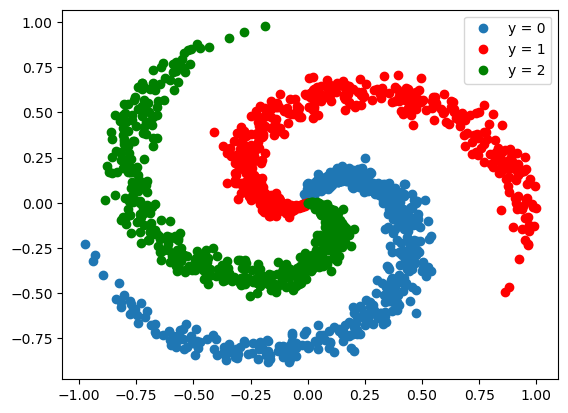

In [14]:
ds = Data()
ds.plot_stuff()

In [65]:
torch.manual_seed(2)

layers1 = [2, 50, 3]
layers2 = [2, 8, 8, 3]

model1 = Net(layers1)
model2 = Net(layers2)

criterion = nn.CrossEntropyLoss()

optimizer1 = optim.SGD(model1.parameters(), lr = 0.085)
optimizer2 = optim.SGD(model2.parameters(), lr = 0.085)

In [66]:
def train(model, criterion, tl, optimizer, epochs = 100):
    
    COST = []
    
    for epoch in range(epochs):
        
        for x,y in tl:
            
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            COST.append(loss.item())
            optimizer.step()
            
    return COST

In [67]:
loader = DataLoader(dataset=ds, batch_size = 20)

l1 = train(model1, criterion, loader, optimizer1)
l2 = train(model2, criterion, loader, optimizer2)

In [68]:
def plot_avg(loss):
    
    l = len(loss)
    newList = []
    s = 0
    
    for i in range(1, l):
        
        s += loss[i]
        
        if i % 100 == 0:
            
            avg = s/i
            newList.append(avg)
            s = 0
            
    return newList
            

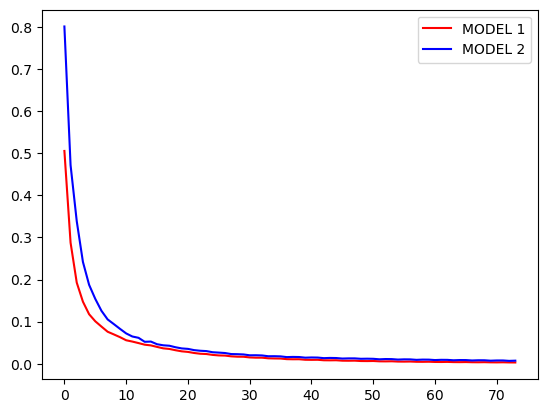

In [69]:
plt.plot(plot_avg(l1), c='r', label='MODEL 1')
plt.plot(plot_avg(l2), c='b', label='MODEL 2')
plt.legend()
plt.show()

In [73]:
def plot_decision(model, data_set, title):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title(title)
    plt.legend()

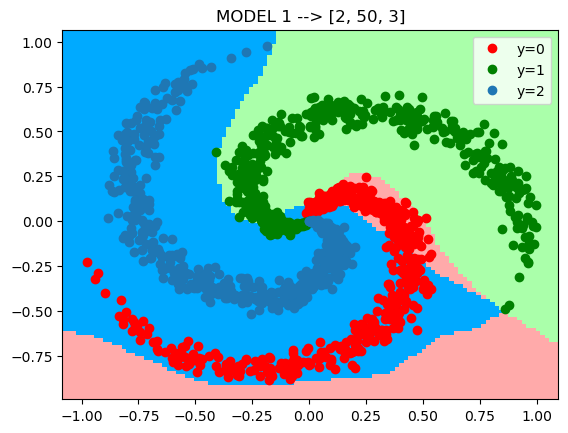

In [77]:
plot_decision(model1, ds, ('MODEL 1 --> ' + str(layers1)))

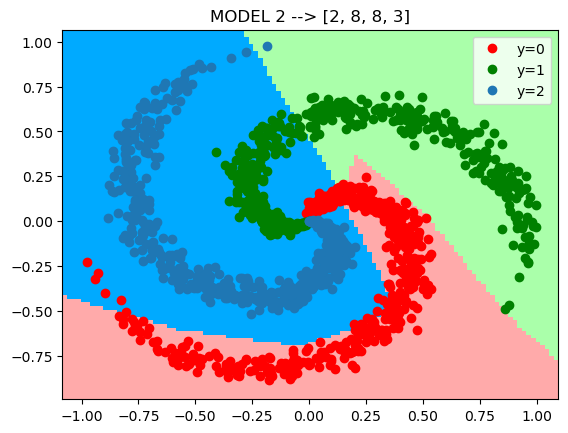

In [79]:
plot_decision(model2, ds, ('MODEL 2 --> ' + str(layers2)))